# Generative Adversarial Networks

В этом ноутбуке мы реализуем полносвязные и 'сверточные' генераторы и дискриминаторы

# 1-ое задание

В этом задании реализуем 2 вида генератора и дискриминатора

# Libraries

In [1]:
import os

import cv2
import torch
import torchvision
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\Ученик-ФМШ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_kwargs = {}
if torch.cuda.is_available():
    train_kwargs['gpus'] = torch.cuda.device_count()
train_kwargs['max_epochs'] = 20
if torch.cuda.is_available():
    train_kwargs['max_epochs'] = 200
print(train_kwargs)

{'max_epochs': 20}


# Data

Создадим опять же датасеты для MNIST

In [3]:
dataset_root = "../2nd Task/"
images_dir, labels_dir = "Mnist_X.npy", "Mnist_y.npy"
images, labels = np.load(os.path.join(dataset_root, images_dir)), np.load(os.path.join(dataset_root, labels_dir))
print(images.shape[0])

70000


In [4]:
BATCH_SIZE = 128
IMAGE_SIZE = (28, 28)
NOISE_DIM = 100
LOW_RES_SIZE = IMAGE_SIZE

In [5]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, target_size=None):
        #TODO: set class values
        self.target_size = target_size
        self.all_images = X
        self.all_labels = y
    
    def __len__(self):
        return self.all_images.shape[0]
    
    def __getitem__(self, idx):
        
        image = self.all_images[idx]
        #TODO: cast image to rgb
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        if self.target_size is not None:
            image_rgb = cv2.resize(image_rgb, self.target_size)
        
        # Приводим изображение к [0, 1]
        image_rgb = (image_rgb / 255).astype(np.float32)
        
        return torch.from_numpy(image_rgb * 2 - 1) #tanh values in [-1, 1]

In [6]:
class MNISTGANDataModule(pl.LightningDataModule):
    def __init__(self, X, y, batch_size, shuffle=True):
        super().__init__()

        #TODO: установите параметры класса
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.X = X
        self.y = y
    
    def setup(self, stage=None):
        self.dataset = MNISTDataset(self.X, self.y, target_size=IMAGE_SIZE)
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=self.shuffle)

## Вспомогательные функции визуализации

In [7]:
def data2img(d: np.ndarray):
    return 0.5 * d + 0.5

def visualize_images(data, n_rows, n_cols):
    n_samples = n_rows * n_cols

    if len(data) != n_samples:
        sample_indices = np.random.choice(len(data), n_samples, replace=len(data) < n_samples)
    else:
        sample_indices = np.arange(len(data)).astype(int)

    plt.figure(figsize=(int(2.5 * n_cols), int(2.5 * n_rows)))
    for i, sample_index in enumerate(sample_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(data2img(data[sample_index]))
        plt.axis("off")
    plt.show()

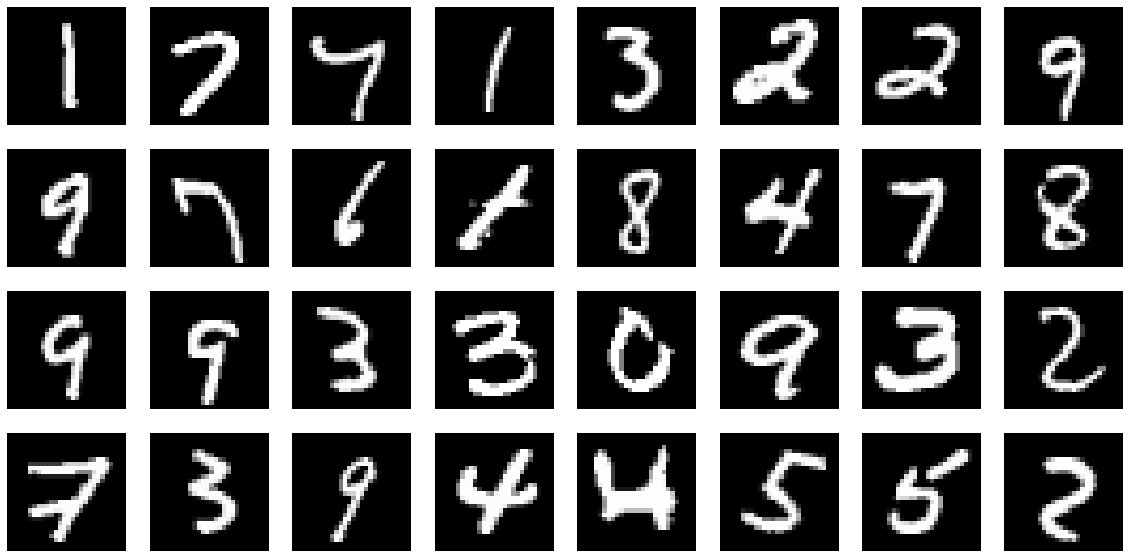

In [8]:
dm = MNISTGANDataModule(images, labels, batch_size=32)
dm.setup()
visualize_images(next(iter(dm.train_dataloader())), 4, 8)

# Полносвязные генератор и дискриминатор

Создадим генератор, архитектура которого будет выглядеть так:
1. Из `100=NOISE_DIM` через линейный слой отобразим в **1024** элемента;
2. Применим `ReLU` с параметром `inplace=True` для некоторой экономии памяти;
3. Затем отобразим результат через линейный слой в **1024**;
4. Опять применим `ReLU` как в пункте 2;
5. Из **1024** отобразим линейным слоем в итоговое разрешение `28x28x3`;
6. Применим функцию активации `tanh`.

In [9]:
class FCGenerator(nn.Module):
    def __init__(self, noise_dim: int, img_shape: tuple):
        super().__init__()
        self.img_shape = img_shape
        
        self.model = nn.Sequential(
            #TODO: описать слои
            nn.Linear(noise_dim, 1024),# Линейный 100 в 1024
            nn.ReLU(inplace = True),# ReLU
            nn.Linear(1024, 1024),# Линейный 1024 в 1024
            nn.ReLU(inplace = True),# ReLU
            nn.Linear(1024, 28*28*3),# Линейный 1024 в 28*28*3
            nn.Tanh(),# Tanh
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)  # keep batch size
        return img

Небольшой тест.

In [10]:
fc_gen = FCGenerator(NOISE_DIM, IMAGE_SIZE + (3,))
img_generated = fc_gen(torch.randn(32, NOISE_DIM))

assert img_generated.shape[1:] == IMAGE_SIZE + (3,)

Создадим дискриминатор, архитектура которого будет выглядеть так:

1. Представить изображение в виде одномерного вектора через `nn.Flatten()`;
2. Через линейное преобразование из итогового разрешения отоборазим в **256** элементов;
3. Применим `LeakyReLU(0.01)`;
4. Линейным слоем отобразим в **256** элементов;
5. Опять `LeakyReLU(0.01)`;
6. Линейным отображением в **1** элемент;
7. Наконец, нелинейное отображение через `Sigmoid` (но только, если решаем классификации);

In [11]:
class FCDiscriminator(nn.Module):
    def __init__(self, img_shape: tuple, classify: bool = True):
        super().__init__()

        self.model = nn.Sequential(
            #TODO: Описать слои
            nn.Flatten(),# Представить изображение вектором
            nn.Linear(np.prod(img_shape), 256),# Линейный слой в 256,
            nn.LeakyReLU(0.01),# LeakyReLU
            nn.Linear(256, 256),# Линейный из 256 в 256
            nn.LeakyReLU(0.01),# LeakyReLU
            nn.Linear(256, 1),# Линейный 256 в 1
        )

        # Если дискриминатор классифицирует, то добавим Sigmoid
        if classify:
            self.model.add_module('sigm', nn.Sigmoid())
    
    def forward(self, img):
        img_flat = img
        return self.model(img_flat)

In [12]:
fc_dis = FCDiscriminator(IMAGE_SIZE + (3,))
prob_dis = fc_dis(img_generated)

assert prob_dis.shape[1:] == (1,)

# Сверточный генератор и дискриминатор

> Здесь и далее `ReLU` с параметром `inplace=True`

Создадим генератор с следующей архитектурой архитектурой:
1. Сначала через линейный слой отобразим в **128\*7\*7**;
2. Затем полученный вектор представим модулем, определенным в следующей ячейке в **128, 7, 7**;
3. К результату применим `ReLU`;
4. Затем используем `UpSample` слой с увеличением разрешения в 2 раза;
5. Затем применим свертку из исходного разрешения 
    
    **128, 7, 7** в **128** слоев с размером ядра **3**, добавляя нули к исходному изображению так, 
    
    чтобы в итоге получилось изображение размеров, как в результате пункта 4 -- `padding='same'`
6. Используем нормализацию с параметром момента `momentum=0.8`;
7. Опять применение `ReLU`;
8. Повторим п.4-7, но свертки п.5 уже в **64** слоя;
9. Используем свертку для преобразования в **3** канала из 64-х;
10. Используем слой активации `nn.Tanh()`;

In [13]:
class Reshape(nn.Module):
    def __init__(self, new_shape: tuple):
        super().__init__()
        self.new_shape = new_shape
        
    def forward(self, z):
        return z.reshape(z.size(0), *self.new_shape)

In [14]:
class DCGenerator(nn.Module):
    def __init__(self, noise_dim: int, img_shape: tuple):
        super().__init__()
        self.img_shape = img_shape
        
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128*7*7),# Линейный 100 в 128*7*7
            Reshape((128, 7, 7)),# Представим вектор в виде 1128 каналов фрагментов 7х7
            nn.ReLU(inplace=True),# ReLU
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding="same"),# Свертка 128 в 128 ядром 3x3, padding='same'
            nn.BatchNorm2d(128, momentum=0.8),# Нормализация с моментом 0.8
            nn.ReLU(inplace=True),# ReLU
            nn.Upsample(scale_factor=2),# Апсемпл
            nn.Conv2d(128, 64, kernel_size=3, padding="same"),# Свертка из 128 в 64 ядром 3х3 padding='same'
            nn.BatchNorm2d(64, momentum=0.8),# Норамлизация с моментом 0.8
            nn.ReLU(inplace=True),# ReLU
            nn.Conv2d(64, 3, kernel_size=3, padding="same"),# Свертка из 64 в 3 ядром 3х3 padding='same'
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.permute(0, 2, 3, 1)  # make channel axis last
        return img

In [15]:
dc_gen = DCGenerator(NOISE_DIM, IMAGE_SIZE + (3,))
fake_imgs = dc_gen(torch.randn(10, NOISE_DIM))

assert fake_imgs.shape[1:] == IMAGE_SIZE + (3,)

Создаем сверточный дискриминатор с архитектурой:
1. Свертка из исходного разрешения в **32** с параметрами `kernel_size=3, stride=2, padding=1` - последнее есть аналог `padding='same'`, но при заданном шаге `stride` нужно устанавливать только числовой показатель
2. Leaky ReLU(0.2)
3. Dropout(0.25)
4. Conv2D: 3x3, filters=64, strides=2, padding="same"
5. Zero Padding 2D: ((0, 1), (0, 1))
6. Batch Normalization 2D with momentum(0.8)
7. Leaky ReLU(0.2)
8. Dropout(0.25)
9. Conv2D: 3x3, filters=128, strides=2, padding="same"
10. Batch Normalization 2D with momentum(0.8)
11. Leaky ReLU(0.2)
12. Dropout(0.25)
13. Conv2D: 3x3, filters=256, strides=2, padding="same"
14. Batch Normalization 2D with momentum(0.8)
15. Leaky ReLU(0.2)
16. Dropout(0.25)
17. Flatten
18. Fully connected layer with output size 1
19. Sigmoid

In [16]:
class DCDiscriminator(nn.Module):
    def __init__(self, img_shape: tuple, classify: bool = True):
        super().__init__()

        self.model = nn.Sequential(
            # TODO: Описать модель
            nn.Conv2d(img_shape[2], 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d( 32, 64, kernel_size=3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Flatten(),
            nn.Linear(256*2*2, 1)
        )
        
        # Если задача классификации, то добавить слой Sigmoid
        if classify:
            self.model.add_module('sigm', nn.Sigmoid())
    
    def forward(self, img):
        img_chan = img.permute(0, 3, 1, 2)  # channels first
        return self.model(img_chan)

In [17]:
dc_dis = DCDiscriminator(img_shape=IMAGE_SIZE + (3,))
fake_proba = dc_dis(fake_imgs)

assert fake_proba.shape[1:] == (1,)

# 2-ое задание

В этом задании реализуем модель GAN и обучим его

# Net training

## FCGan

In [18]:
class FCGAN(pl.LightningModule):
    def __init__(self, width, height, channels, noise_dim=100, lr=0.0002, b1=0.5, b2=0.999):
        super().__init__()
        self.save_hyperparameters()  # make <arg> available as self.hparams.<arg>
        
        img_shape = (width, height, channels)
        self.generator = FCGenerator(noise_dim=self.hparams.noise_dim, img_shape=img_shape) # TODO: Создайте описанный FCGenerator с параметрами noise_dim=self.hparams.noise_dim, img_shape=img_shape
        self.discriminator = FCDiscriminator(img_shape=img_shape) # TODO: Создайте дискриминатор с параметром img_shape=img_shape
        
        # Создадим валидационный наборчик, который будет отображаться по мере обучения сети
        self.validation_z = torch.randn(8, noise_dim)
    
    def forward(self, z):
        # Основная идея сети - генерировать изображения, 
        # поэтому в вызове model(...) должен вызываться генератор
        return self.generator(z)
    
    def gan_loss(self, y_hat, y):
        # TODO: Реализуйте ошибку классификации(hint: binary cross entropy)
        loss = nn.BCELoss()
        return loss(y_hat, y)
    
    def training_step(self, imgs, batch_idx, optimizer_idx):

        # Создаем случайные экземпляры, которые будут в роли G(z)
        z = torch.randn(imgs.size(0), self.hparams.noise_dim)
        z = z.type_as(imgs)  # move to same device as imgs
        
        if optimizer_idx == 0:  # generator
            # TODO: получить синтетические изображения
            self.generated_imgs = self(z)# forvard(self, z)
            
            # Создадим вектор "правильных" ответов дискриминатора 
            # - хотим, чтобы дискриминатор относил синтетику к правде
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)
            
            # TODO: Посчитать ошибку
            g_loss = self.gan_loss(self.discriminator(self.generated_imgs), valid)

            self.log('g_loss', g_loss, prog_bar=True)
            return {'loss': g_loss}
        
        if optimizer_idx == 1:  # discriminator
            # Сразу создаем вектор правильных ответов на существующие изображения
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            # TODO: Посчитать первое слагаемое ошибки дискриминатора - настоящие изображения должны относиться к настоящим
            real_loss = self.gan_loss(self.discriminator(imgs), valid)
            
            # Теперь создаем аналогичный вектор, но из нулей для синтетических изображений
            fake = torch.zeros(imgs.size(0), 1)
            fake = fake.type_as(imgs)

            # TODO: Посчитать второе слагаемое для ошибки - синтетические изображения должны быть таковыми 
            # P.s чтобы не было ошибок, после self(...) допишите self(...).detach()
            fake_loss = self.gan_loss(self.discriminator(self(z).detach()), fake)
            
            # Ошибка будет средним этих значений(чтобы была в тех же диапазонах, что и у генератора)
            d_loss = (real_loss + fake_loss) / 2

            self.log('d_loss', d_loss, prog_bar=True)
            return {'loss': d_loss}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        # Создаем два идентичных оптимизатора, но один для генератора, второй для дискриминатора
        # В обучающем шаге будем использовать эту информацию, чтобы знать, с каким фрагментом работаем
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        # send results for validation_z to TensorBoard
        z = self.validation_z.type_as(self.generator.model[0].weight)
        sample_imgs = self(z).permute(0, 3, 1, 2)  # channels before pixels
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

In [43]:
# Создаем набор данных(для упрощения обучения возьмем часть выборки)
dm = MNISTGANDataModule(images[:10000], labels[:10000], batch_size=BATCH_SIZE)
# Создаем модель
fcmodel = FCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
# Выбираем учителя
trainer = pl.Trainer(**train_kwargs)
# Запускаем процесс обучения
trainer.fit(fcmodel, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Ученик-ФМШ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\trainer\configuration_validator.py:307: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
Missing logger folder: c:\Users\Ученик-ФМШ\Desktop\Презентации\4th Task\lightning_logs

  | Name          | Type            | Params
--------------------------------------------------
0 | generator     | FCGenerator     | 3.6 M 
1 | discriminator | FCDiscriminator | 668 K 
--------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.929    Total estimated 

Epoch 19: 100%|██████████| 79/79 [00:10<00:00,  7.81it/s, loss=0.922, v_num=0, g_loss=1.690, d_loss=0.425]


In [19]:
# Визуализируем результат
visualize_images(fcmodel(torch.randn(32, NOISE_DIM)).detach(), 4, 8)

NameError: name 'fcmodel' is not defined

## Загрузим предобученную сеть

Загрузим обученную сеть и произведем аналогичный вывод, посмотрим на возможный результат

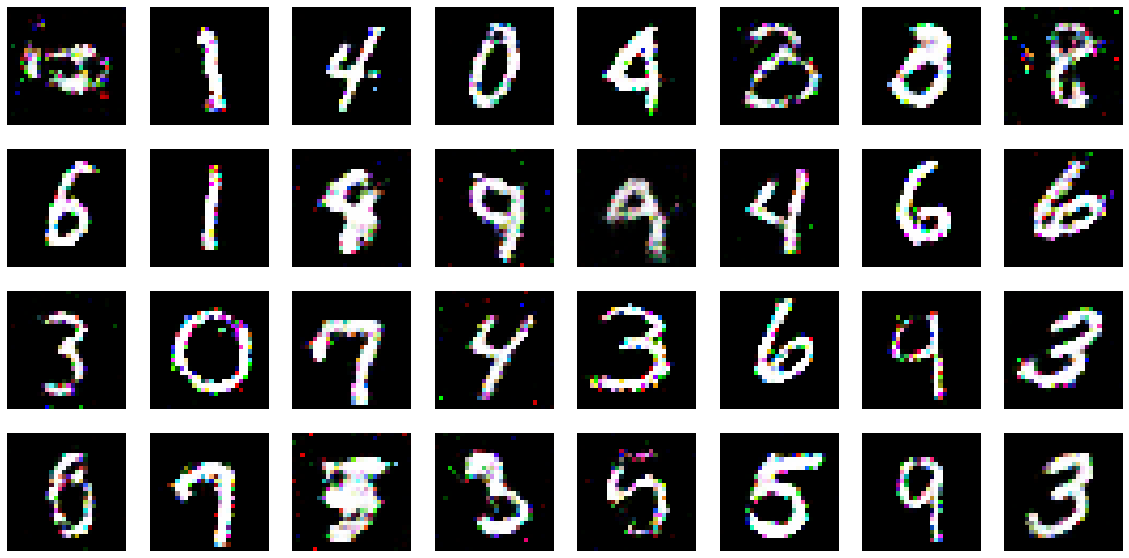

In [20]:
pretrainedFCGAN = FCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
pretrainedFCGAN.load_state_dict(torch.load("modelsWeights/fcgan200"))
pretrainedFCGAN.eval()

visualize_images(pretrainedFCGAN(torch.randn(32, NOISE_DIM)).detach(), 4, 8)

## DCGan

Теперь создадим аналогичный сверточный GAN и посмотрим на его работу

In [21]:
class DCGAN(pl.LightningModule):
    def __init__(self, width, height, channels, noise_dim=100, lr=0.0002, b1=0.5, b2=0.999):
        super().__init__()
        self.save_hyperparameters()  # make <arg> available as self.hparams.<arg>
        
        img_shape = (width, height, channels)
        # TODO: Создайте генератор и дискриминатор с аналогичными параметрами, что и в FCGAN, но тут уже DC...
        self.generator = DCGenerator(noise_dim=self.hparams.noise_dim, img_shape=img_shape) # TODO: Создайте описанный FCGenerator с параметрами noise_dim=self.hparams.noise_dim, img_shape=img_shape
        self.discriminator = FCDiscriminator(img_shape=img_shape)
        
        # Создаем валидационные примеры для визуализации результатов
        self.validation_z = torch.randn(8, noise_dim)
    
    def forward(self, z):
        # TODO: Реализуйте применение GAN'а
        return self.generator(z)
    
    def gan_loss(self, y_hat, y):
        # TODO: Реализуйте ошибку классификации(hint: binary cross entropy)
        loss = nn.BCELoss()
        return  loss(y_hat, y)
    
    def training_step(self, imgs, batch_idx, optimizer_idx):

        # Создаем элементы латентного пространства
        z = torch.randn(imgs.size(0), self.hparams.noise_dim)
        z = z.type_as(imgs)  # move to same device as imgs
        
        if optimizer_idx == 0:  # generator
            # TODO: получить синтетические изображения
            self.generated_imgs = self(z)
            
            # Создадим вектор "правильных" ответов дискриминатора 
            # - хотим, чтобы дискриминатор относил синтетику к правде
            valid = torch.ones(imgs.size(0), 1)  # all fake, but we want to be real
            valid = valid.type_as(imgs)
            
            # TODO: Посчитать ошибку
            g_loss = self.gan_loss(self.discriminator(self.generated_imgs), valid)
            
            self.log('g_loss', g_loss, prog_bar=True)
            return {'loss': g_loss}
        
        if optimizer_idx == 1:  # discriminator
            # Сразу создаем вектор правильных ответов на существующие изображения
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)

            # TODO: Посчитать первое слагаемое ошибки дискриминатора - настоящие изображения должны относиться к настоящим
            real_loss = self.gan_loss(self.discriminator(imgs), valid)
            
            # Теперь создаем аналогичный вектор, но из нулей для синтетических изображений
            fake = torch.zeros(imgs.size(0), 1)
            fake = fake.type_as(imgs)

            # TODO: Посчитать второе слагаемое для ошибки - синтетические изображения должны быть таковыми 
            # P.s чтобы не было ошибок, после self(...) допишите self(...).detach()
            fake_loss = self.gan_loss(self.discriminator(self(z).detach()), fake)
            
            # Ошибка будет средним этих значений(чтобы была в тех же диапазонах, что и у генератора)
            d_loss = (real_loss + fake_loss) / 2
            self.log('d_loss', d_loss, prog_bar=True)
            return {'loss': d_loss}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        # Создаем два идентичных оптимизатора, но один для генератора, второй для дискриминатора
        # В обучающем шаге будем использовать эту информацию, чтобы знать, с каким фрагментом работаем
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        # send results for validation_z to TensorBoard
        z = self.validation_z.type_as(self.generator.model[0].weight)
        sample_imgs = self(z).permute(0, 3, 1, 2)  # channels before pixels
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

In [58]:
# Создаем датасет(для упрощения работы на части выборки)
dm = MNISTGANDataModule(images[:1000], labels[:1000], batch_size=BATCH_SIZE)
# Создаем модель
dcmodel = DCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
# Выбираем учителя(сеть сильно сложнее предыдущей, поэтому данных меньше и эпох тоже, иначе придется долго ждать:( )
trainer = pl.Trainer(max_epochs=10)
# Обучаем сеть
trainer.fit(dcmodel, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type            | Params
--------------------------------------------------
0 | generator     | DCGenerator     | 856 K 
1 | discriminator | FCDiscriminator | 668 K 
--------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.102     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 8/8 [00:11<00:00,  1.49s/it, loss=0.724, v_num=4, g_loss=0.609, d_loss=0.958]


In [22]:
visualize_images(dcmodel(torch.randn(32, NOISE_DIM)).detach(), 4, 8)

NameError: name 'dcmodel' is not defined

## Загрузим предобученную сеть

Загрузим обученную сеть и произведем аналогичный вывод, посмотрим на возможный результат

In [29]:
pretrainedDCGAN = DCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
pretrainedDCGAN.load_state_dict(torch.load("modelsWeights/dcgan200"))
pretrainedDCGAN.eval()

visualize_images(pretrainedDCGAN(torch.randn(32, NOISE_DIM)).detach(), 4, 8)

# 3-е задание

В этом задании рассмотрим модификацию предыдущих GAN'ов и сравним результаты.

# Wasserstein GAN

In [ ]:
class WFCGAN(pl.LightningModule):
    def __init__(self, width, height, channels, noise_dim=100, lr=0.0002, b1=0.5, b2=0.999):
        super().__init__()
        self.save_hyperparameters()  # make <arg> available as self.hparams.<arg>
        
        img_shape = (width, height, channels)
        # TODO: Создать FC генератор и дискриминатор(не забыть про то, что дискриминатор не занимается задачей классификации)
        self.generator = FCGenerator(noise_dim=self.hparams.noise_dim, img_shape=img_shape)
        self.discriminator = FCDiscriminator(img_shape=img_shape, classify=False)
        
        # Создаем валидационные примеры для визуализации результатов
        self.validation_z = torch.randn(8, noise_dim)
    
    def forward(self, z):
        # TODO: Реализовать прямой проход GAN'а
        return self.generator(z)
    
    def gan_loss(self, y_hat):
        # TODO: реализовать ошибку WE
        loss = -torch.mean(y_hat)
        return  loss
    
    def training_step(self, imgs, batch_idx, optimizer_idx):

        # Создаем элементы латентного пространства
        z = torch.randn(imgs.size(0), self.hparams.noise_dim)
        z = z.type_as(imgs)  # move to same device as imgs
        
        # Специальное значение для ограничения ошибок
        clip_value = 0.01
        
        if optimizer_idx == 0:  # generator

            # TODO: Создать синтетические изображения
            self.generated_imgs = self(z)
            
            # TODO: Посчитать ошибку для генератора
            g_loss = self.gan_loss(self.discriminator(self.generated_imgs))

            self.log('g_loss', g_loss, prog_bar=True)
            return {'loss': g_loss}
        
        if optimizer_idx == 1:  # discriminator

            # TODO: Посчитать ошибку для дискриминатора
            d_loss =  (self.gan_loss(self.discriminator(imgs) - self.discriminator(self(z))))
            
            # Специальное ограничение параметров, чтобы избежать взырвных градиентов
            for p in self.discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)
                
            self.log('d_loss', d_loss, prog_bar=True)
            return {'loss': d_loss}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        # Создаем два идентичных оптимизатора, но один для генератора, второй для дискриминатора
        # В обучающем шаге будем использовать эту информацию, чтобы знать, с каким фрагментом работаем
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        # send results for validation_z to TensorBoard
        z = self.validation_z.type_as(self.generator.model[0].weight)
        sample_imgs = self(z).permute(0, 3, 1, 2)  # channels before pixels
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

In [25]:
dm = MNISTGANDataModule(images[:10000], labels[:10000], batch_size=BATCH_SIZE)
wfcmodel = WFCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
trainer = pl.Trainer(**train_kwargs)
trainer.fit(wfcmodel, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type            | Params
--------------------------------------------------
0 | generator     | FCGenerator     | 3.6 M 
1 | discriminator | FCDiscriminator | 668 K 
--------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.929    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 79/79 [00:10<00:00,  7.55it/s, loss=-0.0123, v_num=6, g_loss=0.00498, d_loss=1.77e-5] 


Epoch 6:  72%|███████▏  | 57/79 [03:50<01:28,  4.04s/it, loss=-0.504, v_num=5, g_loss=-1.34, d_loss=-.529]


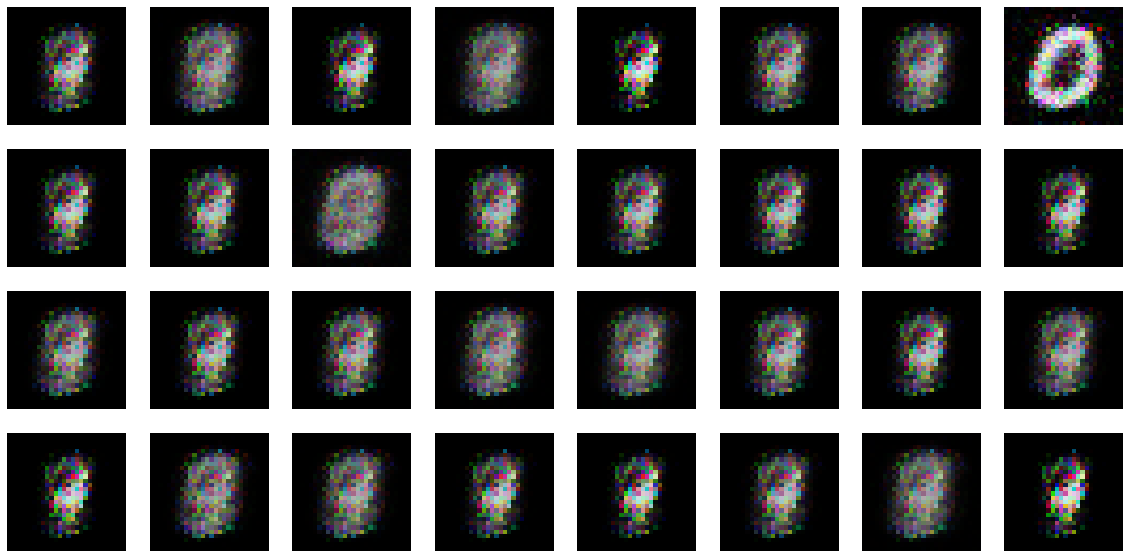

In [26]:
visualize_images(wfcmodel(torch.randn(32, NOISE_DIM)).detach(), 4, 8)

## Загрузим предобученную сеть

Загрузим сеть, обученную на **всех** данных за **200 эпох** и визуализируем результаты.

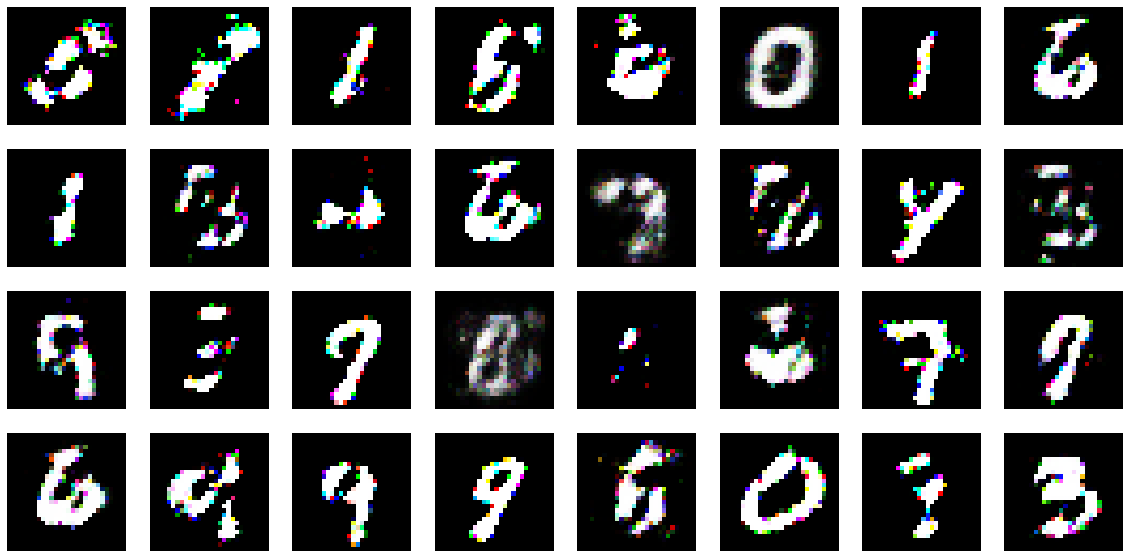

In [28]:
pretrainedWFCGAN = WFCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
pretrainedWFCGAN.load_state_dict(torch.load("modelsWeights/wfcgan200"))
pretrainedWFCGAN.eval()

visualize_images(pretrainedWFCGAN(torch.randn(32, NOISE_DIM)).detach(), 4, 8)

-----

# WDCGAN(LSGAN)

In [31]:
class WDCGAN(pl.LightningModule):
    def __init__(self, width, height, channels, noise_dim=100, lr=0.0002, b1=0.5, b2=0.999):
        super().__init__()
        self.save_hyperparameters()  # make <arg> available as self.hparams.<arg>
        
        img_shape = (width, height, channels)
        # TODO: Создать DC генератор и дискриминатор(не забыть про то, что дискриминатор не занимается задачей классификации)
        self.generator = DCGenerator(noise_dim=self.hparams.noise_dim, img_shape=img_shape)
        self.discriminator = DCDiscriminator(img_shape=img_shape, classify=False)
        
        # Создаем валидационные примеры для визуализации результатов
        self.validation_z = torch.randn(8, noise_dim)
        
    def forward(self, z):
        # TODO: Реализовать прямой проход GAN'а
        return self.generator(z)
    
    def ls_loss(self, y_hat, y):
        # TODO: Реализовать ошибку LSGAN
        return 1/2 * torch.mean((y_hat - 1)**2) + torch.mean(y**2)
    
    def training_step(self, imgs, batch_idx, optimizer_idx):

        # Создаем элементы латентного пространства
        z = torch.randn(imgs.size(0), self.hparams.noise_dim)
        z = z.type_as(imgs)  # move to same device as imgs
        
        if optimizer_idx == 0:  # generator

            # TODO: Создать синтетические изображения
            self.generated_imgs = self(z)

            # Cчитаем ошибку генератора, там только одно слагаемое, значит второе специально сделаем нулем
            d_fake = torch.zeros(imgs.size(0), 1)

            # TODO: Посчитать ошибку генератора
            g_loss =  self.ls_loss(self.discriminator(self.generated_imgs), d_fake)
            
            self.log('g_loss', g_loss, prog_bar=True)
            return {'loss': g_loss}
        
        if optimizer_idx == 1:  # discriminator

            # TODO: Посчитать ошибку дискриминатора(после self(...) написать .detach())
            d_loss = self.ls_loss(self.discriminator(imgs), self.discriminator(self(z).detach()))
            
            self.log('d_loss', d_loss, prog_bar=True)
            return {'loss': d_loss}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        # Создаем два идентичных оптимизатора, но один для генератора, второй для дискриминатора
        # В обучающем шаге будем использовать эту информацию, чтобы знать, с каким фрагментом работаем
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)
        sample_imgs = self(z).permute(0, 3, 1, 2)  # channels before pixels
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

In [32]:
dm = MNISTGANDataModule(images[:1000], labels[:1000], batch_size=BATCH_SIZE)
wdcmodel = WDCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(wdcmodel, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Ученик-ФМШ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\trainer\configuration_validator.py:307: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(

  | Name          | Type            | Params
--------------------------------------------------
0 | generator     | DCGenerator     | 856 K 
1 | discriminator | DCDiscriminator | 390 K 
--------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.989     Total estimated model params size (MB)
C:\Users\Ученик-ФМШ\AppData\Local\Packages\PythonSoftwareFoundat

Epoch 9: 100%|██████████| 8/8 [00:17<00:00,  2.23s/it, loss=0.363, v_num=8, g_loss=0.723, d_loss=0.387]


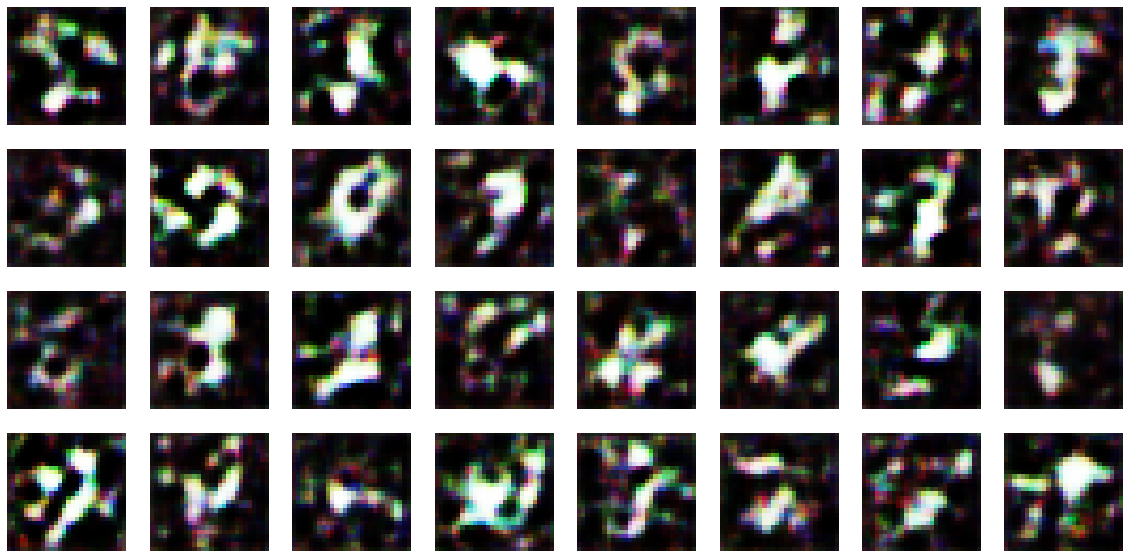

In [33]:
visualize_images(wdcmodel(torch.randn(32, NOISE_DIM)).detach(), 4, 8)

## Загрузим предобученную сеть

Загрузим сеть, обученную на **всех** данных за **200 эпох** и визуализируем результаты.

In [34]:
pretrainedWDCGAN = WDCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
pretrainedWDCGAN.load_state_dict(torch.load("modelsWeights/wdcgan200"))
pretrainedWDCGAN.eval()

visualize_images(pretrainedWDCGAN(torch.randn(32, NOISE_DIM)).detach(), 4, 8)

RuntimeError: Error(s) in loading state_dict for WDCGAN:
	Missing key(s) in state_dict: "discriminator.model.18.weight", "discriminator.model.18.bias". 
	Unexpected key(s) in state_dict: "discriminator.model.17.weight", "discriminator.model.17.bias". 